# Layer-wise Relevance Propagation using Abstract Semiring elements for the XOR problem

In [22]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [23]:
class MultipleInitialisation(Exception):
    pass

class Semiring():
    #value = None

    def __init__(self, relevance=None, activation=None, weight=None, standard=None):
        if relevance is not None:
            assert type(relevance)==np.float32 or type(relevance)==float or type(relevance)==np.float64, f"must be of type float, is of type {type(relevance)}"
            self.value = relevance
            if activation is not None or weight is not None or standard is not None:
                raise MultipleInitialisation
        if activation is not None:
            assert type(activation)==np.float32 or type(activation)==float or type(activation)==np.float64, f"must be of type float, is of type {type(activation)}"
            self.value = activation
            if relevance is not None or weight is not None or standard is not None:
                raise MultipleInitialisation
        if weight is not None:
            assert type(weight)==np.float32 or type(weight)==float or type(weight)==np.float64, f"must be of type float, is of type {type(weight)}"
            self.value = weight
            if relevance is not None or activation is not None or standard is not None:
                raise MultipleInitialisation
        if standard is not None:
            assert type(standard)==np.float32 or type(standard)==float or type(standard)==np.float64, f"must be of type float, is of type {type(standard)}"
            self.value = standard
            if relevance is not None or activation is not None or weight is not None:
                raise MultipleInitialisation

    def __mul__(self, b):
        f = self.value * b.value
        s = Semiring()
        s.value = f
        return s
    
    def mul(a, b):
        f = a.value * b.value
        s = Semiring()
        s.value = f
        return s
    
    def to_float(self):
        return self.value
    
    def __add__(self, b):
        f = self.value + b.value
        s = Semiring()
        s.value = f
        return s
    
    def __sub__(self, b):
        f = self.value - b.value
        s = Semiring()
        s.value = f
        return s
    
    def pos(self):
        f = max(0, self.value)
        s = Semiring()
        s.value = f
        return s

    def neg(self):
        f = min(0, self.value)
        s = Semiring()
        s.value = f
        return s
    
#from_relevance = np.vectorize(lambda x : Semiring(relevance=x))
from_activation = np.vectorize(lambda x : Semiring(activation=x))
from_weight = np.vectorize(lambda x : Semiring(weight=x))
identity = np.vectorize(lambda x : Semiring(standard=x))
pos = np.vectorize(lambda x : x.pos())
neg = np.vectorize(lambda x : x.neg())

def from_relevance(m):
    return np.array([[Semiring(activation=m[x][y]) for y in range(m.shape[1])] for x in range(m.shape[0])])

def semiring_to_float(m):
    return np.array([[m[x][y].to_float() for y in range(m.shape[1])] for x in range(m.shape[0])])

def lower_bound(A):
    return np.vectorize(identity)(A[0]*0-1)
def upper_bound(A):
    return np.vectorize(identity)(A[0]*0+1)

In [24]:
np.random.seed(0)

EXAMPLES_PER_CLASS = 100
USELESS_FEATURES = 1

train_data = []
train_labels = []

for _ in range(EXAMPLES_PER_CLASS):
    train_data.append([0., 0., np.random.random()])
    train_labels.append(0)

    train_data.append([0., 1., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 0., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 1., np.random.random()])
    train_labels.append(0)

train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)

test_data = []
test_labels = []

for _ in range(EXAMPLES_PER_CLASS//5):
    test_data.append([0., 0., np.random.random()])
    test_labels.append(0.)

    test_data.append([0., 1., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 0., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 1., np.random.random()])
    test_labels.append(0.)

test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

In [25]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2+USELESS_FEATURES, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 2)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [26]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(train_data).squeeze()
    y_preds = torch.argmax(y_logits, dim=1)
    
    loss = loss_fn(y_logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    if epoch % (epochs//10) == 0:
        with torch.inference_mode():
            y_logits = model(test_data).squeeze()
            y_preds = torch.argmax(y_logits, dim=1)
            acc = accuracy_fn(test_labels, y_preds)
            print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7113342881202698 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.6114686131477356 | Accuracy: 93.75
[EPOCH 201/1000] Loss: 0.4647417366504669 | Accuracy: 75.0
[EPOCH 301/1000] Loss: 0.2978476285934448 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.14997734129428864 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.07936517149209976 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.04838308319449425 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.03300571069121361 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.024255048483610153 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.018786797299981117 | Accuracy: 100.0


(-0.10000000149011612, 1.100000023841858)

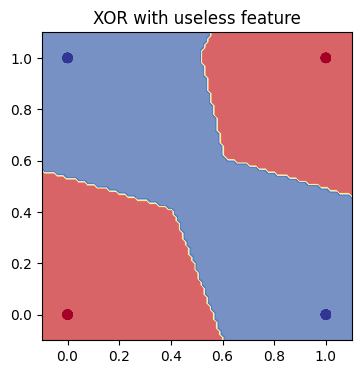

In [27]:
plt.figure(figsize=(4, 4))
plt.title("XOR with useless feature")

x_min, x_max = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
y_min, y_max = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
z_min, z_max = test_data[:, 2].min() - 0.1, test_data[:, 2].max() + 0.1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101), np.linspace(z_min, z_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))).float()

# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.contourf(xx[:,:,0], yy[:,:,0], y_pred[:,:,0], cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [28]:
X = test_data.detach().numpy()
T = test_labels.detach().numpy()

In [29]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [30]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [31]:
i = np.random.randint(0, len(X))
prediction = np.argmax(A[L][i])
print(f"Point: {X[i]}, Pred: {prediction} | Label: {T[i]}")

Point: [1.        0.        0.9894098], Pred: 1 | Label: 1.0


In [32]:
nb_labels = len(np.unique(T))
R = [None] * L + [from_relevance(A[L] * (T[:,None]==np.arange(nb_labels)))]

In [33]:
def rho(w, l):  
    return w #+ [None,0.1,0.0][l] * np.maximum(0,w)
#def incr(z, l):
#    return z + [None,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [34]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(from_weight(W[l]), l)
    #b = rho(B[l], l)

    #z = incr(A[l].dot(w)+b, l)
    s = R[l+1] #/ z
    c = s.dot(w.T)
    R[l] = from_activation(A[l]) * c

In [35]:
def mulmat(A, B):
    p = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            s = Semiring(standard=0)
            for k in range(A.shape[1]):
                print(type(A[i][k].value), type(B[k][j].value))
                s += Semiring.mul(A[i][k], B[k][j])
            p[i][j] = s
    return p

In [36]:
w = from_weight(W[0])
wp = pos(w)
wm = neg(w)
lb = lower_bound(A)
hb = upper_bound(A)

s = R[1]
c = s @ w.T #mulmat(s, w.T)
cp = s @ (wp.T)
cm = s @ (wm.T)
R[0] = from_activation(A[0])*c - lb*cp - hb*cm

    [Layer 0] [25.52264472 13.9257097  -2.47579588]
    [Layer 1] [-0.         -7.72057602 -0.         -0.         -0.          0.
  0.          1.22399486 -0.47974164 12.2436042 ]
    [Layer 2] [2.3288631 0.       ]


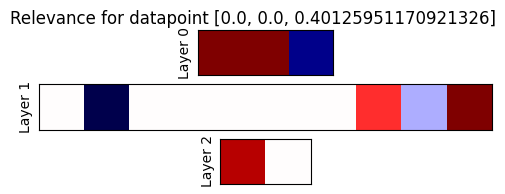

    [Layer 0] [25.52264472 13.9257097  -2.47579588]
    [Layer 1] [-0.         -7.72057602 -0.         -0.         -0.          0.
  0.          1.22399486 -0.47974164 12.2436042 ]
    [Layer 2] [2.3288631 0.       ]


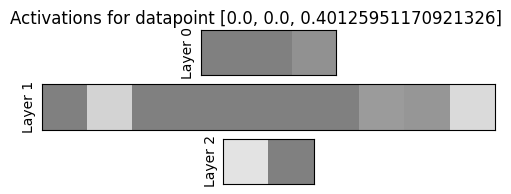

    [Layer 0] [ 9.75037551 18.18697665 -2.34611416]
    [Layer 1] [ 0.          1.77607937  7.26071929  0.          0.         -0.39084207
  0.         -3.6644366   0.04838079 -0.00833643]
    [Layer 2] [0.        2.3447528]


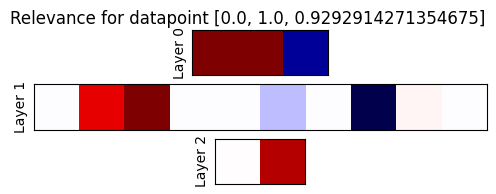

    [Layer 0] [ 9.75037551 18.18697665 -2.34611416]
    [Layer 1] [ 0.          1.77607937  7.26071929  0.          0.         -0.39084207
  0.         -3.6644366   0.04838079 -0.00833643]
    [Layer 2] [0.        2.3447528]


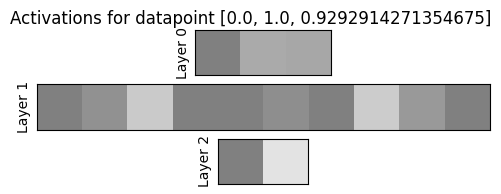

    [Layer 0] [-4.33565463  8.91140024  0.77175991]
    [Layer 1] [ 0.          6.58255469  0.          0.          0.         -0.
  0.         -2.53341843  0.01432109 -0.        ]
    [Layer 2] [0.        2.1199265]


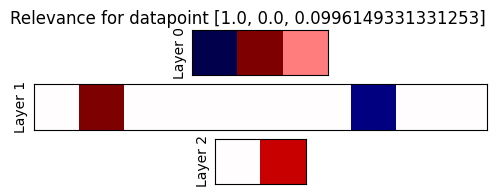

    [Layer 0] [-4.33565463  8.91140024  0.77175991]
    [Layer 1] [ 0.          6.58255469  0.          0.          0.         -0.
  0.         -2.53341843  0.01432109 -0.        ]
    [Layer 2] [0.        2.1199265]


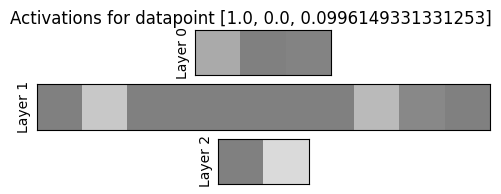

    [Layer 0] [6.62000969 7.15728077 2.66394514]
    [Layer 1] [-0.         -0.65510988 -0.         -0.         -0.          0.15127207
  0.          3.81146242 -0.29442542  0.        ]
    [Layer 2] [1.7697433 0.       ]


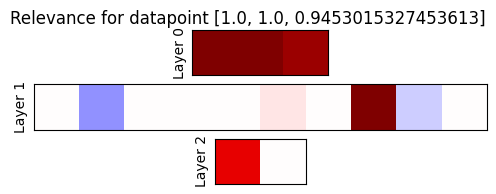

    [Layer 0] [6.62000969 7.15728077 2.66394514]
    [Layer 1] [-0.         -0.65510988 -0.         -0.         -0.          0.15127207
  0.          3.81146242 -0.29442542  0.        ]
    [Layer 2] [1.7697433 0.       ]


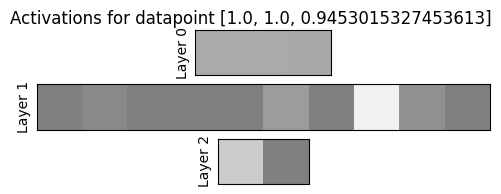

    [Layer 0] [24.18293931 12.5974556  -3.25480548]
    [Layer 1] [-0.         -7.72109432 -0.         -0.         -0.          0.
  0.          1.5081538  -0.66041636 11.51544763]
    [Layer 2] [2.1883745 0.       ]


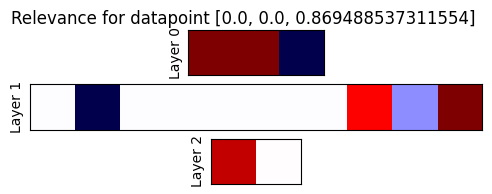

    [Layer 0] [24.18293931 12.5974556  -3.25480548]
    [Layer 1] [-0.         -7.72109432 -0.         -0.         -0.          0.
  0.          1.5081538  -0.66041636 11.51544763]
    [Layer 2] [2.1883745 0.       ]


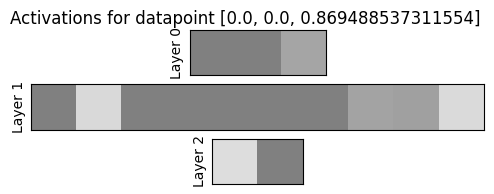

    [Layer 0] [10.16366522 19.30275278 -1.6491108 ]
    [Layer 1] [ 0.          1.23355135  7.32445227  0.          0.         -0.19991179
  0.         -3.27429145  0.0283141  -0.        ]
    [Layer 2] [0.       2.364846]


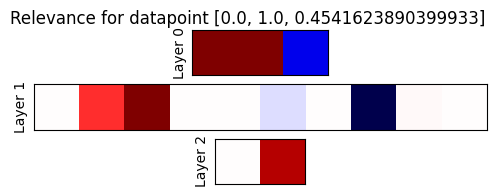

    [Layer 0] [10.16366522 19.30275278 -1.6491108 ]
    [Layer 1] [ 0.          1.23355135  7.32445227  0.          0.         -0.19991179
  0.         -3.27429145  0.0283141  -0.        ]
    [Layer 2] [0.       2.364846]


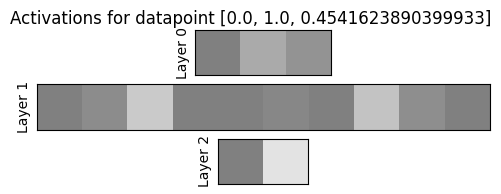

    [Layer 0] [-4.71412876  9.29177522  0.93360646]
    [Layer 1] [ 0.          6.92341502  0.          0.          0.         -0.
  0.         -2.75456919  0.02344123 -0.        ]
    [Layer 2] [0.        2.1515925]


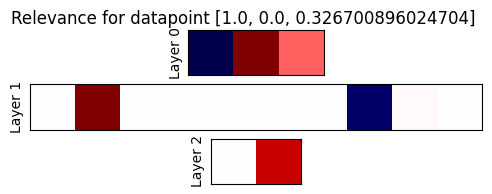

    [Layer 0] [-4.71412876  9.29177522  0.93360646]
    [Layer 1] [ 0.          6.92341502  0.          0.          0.         -0.
  0.         -2.75456919  0.02344123 -0.        ]
    [Layer 2] [0.        2.1515925]


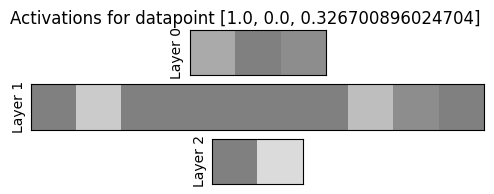

    [Layer 0] [6.44922445 6.96261786 1.97475758]
    [Layer 1] [-0.         -0.08993557 -0.         -0.         -0.          0.10334594
  0.          3.72964999 -0.04033302  0.        ]
    [Layer 2] [1.9581019 0.       ]


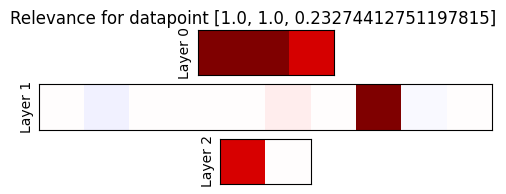

    [Layer 0] [6.44922445 6.96261786 1.97475758]
    [Layer 1] [-0.         -0.08993557 -0.         -0.         -0.          0.10334594
  0.          3.72964999 -0.04033302  0.        ]
    [Layer 2] [1.9581019 0.       ]


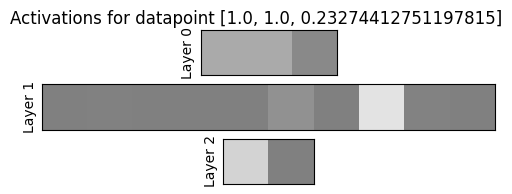

In [37]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

R = [semiring_to_float(x) for x in R]

for i in range(8):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {X[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {X[i].tolist()}")
    plt.show()

### Average relevance
#### Entire dataset

    [Layer 0] R: [ 9.2115482  12.34612242 -0.27441045]
    [Layer 1] R: [ 0.00513217  0.07253585  1.83666265  0.          0.         -0.04219642
  0.         -0.28484938 -0.15364873  3.01229461]
    [Layer 2] R: [1.0418637 1.1273692]


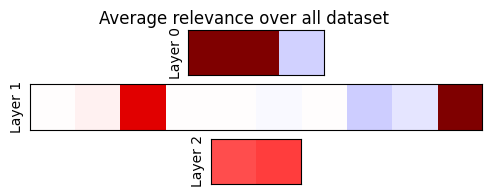

    [Layer 0] A: [0.5        0.5        0.51131016]
    [Layer 1] A: [0.00960249 1.0563555  0.43520433 0.         0.         0.19858772
 0.         1.5849278  0.38886786 0.5326999 ]
    [Layer 2] A: [1.0418637 1.1273692]


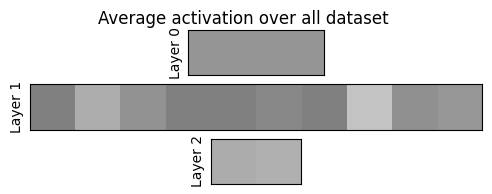

In [38]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    relevance = np.mean(R[l], axis=0)

    axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] R: {relevance}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average relevance over all dataset")
plt.show()

# -- Display activations --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    activation = np.mean(A[l], axis=0)

    axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] A: {activation}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average activation over all dataset")
plt.show()

#### Grouped by class

    [Layer 0] R: [25.17139274 13.58470836 -2.67591842]
    [Layer 1] R: [ 0.         -7.71578762  0.          0.          0.          0.
  0.          1.294269   -0.52461367 12.05372917]
    [Layer 2] R: [2.2922509 0.       ]


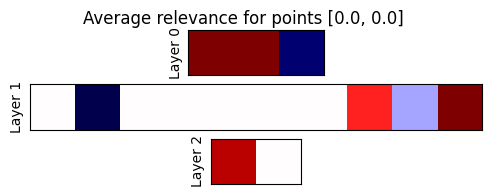

    [Layer 0] A: [0.        0.        0.5232843]
    [Layer 1] A: [0.        2.0118568 0.        0.        0.        0.        0.
 0.701904  0.5853368 2.130032 ]
    [Layer 2] A: [2.2922509 0.       ]


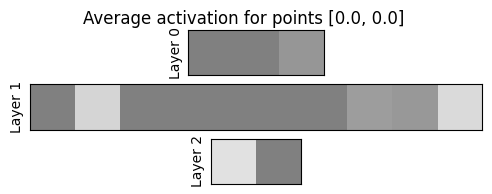

    [Layer 0] R: [10.18749317 19.36270962 -1.67578056]
    [Layer 1] R: [ 2.05594610e-02  1.24474189e+00  7.34665059e+00  0.00000000e+00
  0.00000000e+00 -2.03112797e-01  0.00000000e+00 -3.28985367e+00
  2.86735199e-02 -2.46992956e-03]
    [Layer 2] R: [0.        2.3720198]


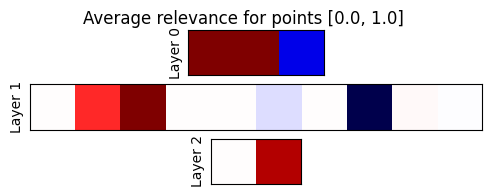

    [Layer 0] A: [0.         1.         0.46363792]
    [Layer 1] A: [3.7081726e-02 2.8797621e-01 1.7408173e+00 0.0000000e+00 0.0000000e+00
 1.8127030e-01 0.0000000e+00 1.5968518e+00 3.4545210e-01 3.9837361e-04]
    [Layer 2] A: [0.        2.3720198]


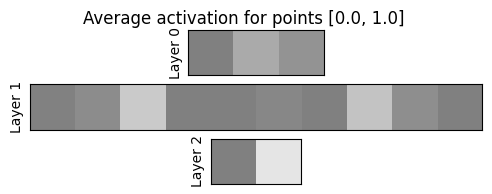

    [Layer 0] R: [-5.02080185  9.40658962  0.99472665]
    [Layer 1] R: [ 0.00000000e+00  7.09482607e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -8.89207557e-02  0.00000000e+00 -2.90040333e+00
  3.12519931e-02 -2.08080469e-03]
    [Layer 2] R: [0.        2.1374564]


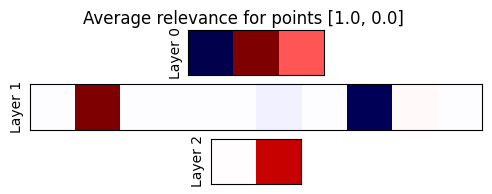

    [Layer 0] A: [1.         0.         0.53105366]
    [Layer 1] A: [0.0000000e+00 1.8161150e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 8.7625213e-02 0.0000000e+00 1.5609499e+00 4.1582337e-01 3.6928654e-04]
    [Layer 2] A: [0.        2.1374564]


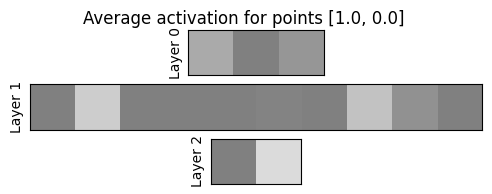

    [Layer 0] R: [6.50810875 7.0304821  2.25933053]
    [Layer 1] R: [-3.07827480e-05 -3.33636932e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.23247885e-01  0.00000000e+00  3.75659048e+00
 -1.49906775e-01  0.00000000e+00]
    [Layer 2] R: [1.8752041 0.       ]


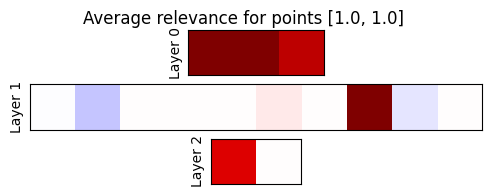

    [Layer 0] A: [1.         1.         0.52726495]
    [Layer 1] A: [1.3282172e-03 1.0947379e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.2545542e-01 0.0000000e+00 2.4800055e+00 2.0885918e-01 0.0000000e+00]
    [Layer 2] A: [1.8752041 0.       ]


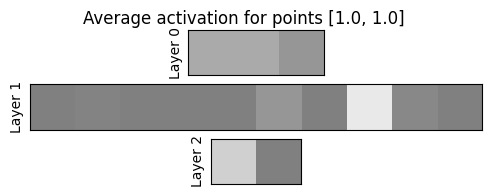

In [39]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)



# -- Display relevance --
for i in range(4):
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        relevance = np.mean(R[l][i::4], axis=0)

        axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] R: {relevance}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    point = X[i].tolist()
    point.pop() # remove useless feature from display

    fig.suptitle(f"Average relevance for points {point}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        activation = np.mean(A[l][i::4], axis=0)

        axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] A: {activation}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Average activation for points {point}")
    plt.show()